**MLP классификатор (TensorFlow)** 

Евгений Борисов  <esborisov@sevsu.ru>

О методах обучения многослойных нейронных сетей прямого распространения.    
http://mechanoid.su/neural-net-backprop.html  
http://mechanoid.su/neural-net-backprop2.html

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)

## генерируем данные

In [3]:
n_samples = 1500

# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=n_samples, centers=2,  cluster_std=[1.5, 1.8,] )

# from sklearn.datasets import make_moons
# X,target = make_moons(n_samples=n_samples, noise=.09)

from sklearn.datasets import make_circles
X,target = make_circles(n_samples=n_samples, shuffle=True, noise=.09, factor=.3)
# X = X+(np.random.rand(X.shape[0],X.shape[1])*0.6)

y = np.eye(2)[target] # [:,np.newaxis]

X.shape, y.shape

((1500, 2), (1500, 2))

In [4]:
# нормируем данные
# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((750, 2), (750, 2), (750, 2), (750, 2))

In [6]:
del X
del y
del target

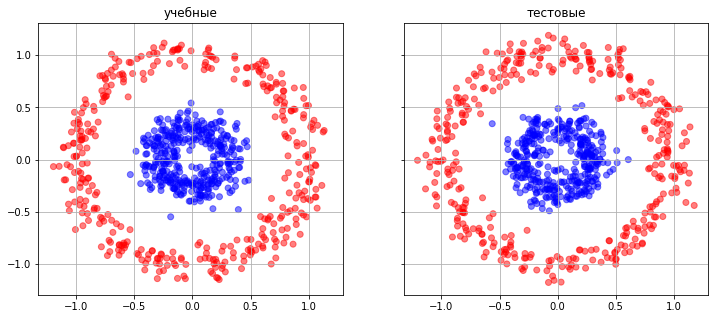

In [7]:
def plot_data(ax,X,y,t):
    c = [ ['b','r','g','y'][j] for j in y.astype(int).flatten()  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5 )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train[:,0],'учебные')    
plot_data(ax1,X_test,y_test[:,0],'тестовые')    
plt.show()

## модель

схема нейрона

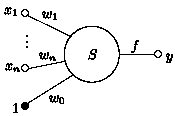

схема MPL 

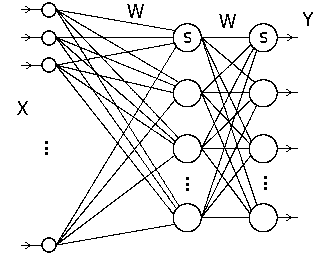

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model 
from tensorflow.keras.layers import Dense 
from tensorflow.nn import sigmoid 

In [ ]:
class MLP(Model):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.dense1 = Dense(units=10) # первый - обрабатывающий/скрытый слой
        self.dense2 = Dense(units=5) # второй - обрабатывающий/скрытый слой
        self.dense3 = Dense(units=output_size) # третий - обрабатывающий/выходной слой

    def call(self, x): 
        o = sigmoid( self.dense1(x) )
        o = sigmoid( self.dense2(o) )
        o = sigmoid( self.dense3(o) )
        return o

In [9]:
model = MLP( input_size=X_train.shape[1], output_size=y_train.shape[1], )
# model.predict(X_train)

## обучаем модель

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.1)
loss = tf.keras.losses.MeanSquaredError()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import Callback

class AccuracyCallback(Callback): 
    
    def on_epoch_end(self, epoch, logs={}): 
        min_acc=.98
        acc = logs.get('accuracy')
        if acc is not None:
            if(logs.get('accuracy') > min_acc):   
                print('\naccuracy threshold reached\n')
                self.model.stop_training = True
        

In [12]:
%%time

result = model.fit(
    tf.cast(X_train,tf.float32),
    tf.cast(y_train,tf.float32),
    batch_size=len(y_train)//3, 
    epochs=135,
    callbacks=[AccuracyCallback()],
)    

Epoch 1/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2540 - accuracy: 0.4947
Epoch 2/135
3/3 [==============================] - 0s 3ms/step - loss: 0.2528 - accuracy: 0.4948
Epoch 3/135
3/3 [==============================] - 0s 3ms/step - loss: 0.2525 - accuracy: 0.4523
Epoch 4/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2503 - accuracy: 0.4962
Epoch 5/135
3/3 [==============================] - 0s 3ms/step - loss: 0.2495 - accuracy: 0.4780
Epoch 6/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2474 - accuracy: 0.5247
Epoch 7/135
3/3 [==============================] - 0s 1ms/step - loss: 0.2448 - accuracy: 0.6808
Epoch 8/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2395 - accuracy: 0.6700
Epoch 9/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2309 - accuracy: 0.6148
Epoch 10/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2174 - accuracy: 0.6507
Epoch 11/135
3/3 [===========

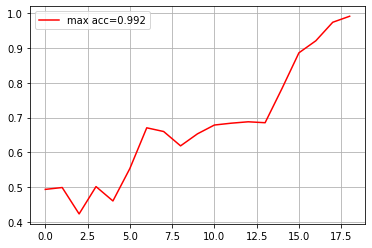

In [13]:
# история изменения значений погрешности модели
plt.plot(result.history['accuracy'],label='max acc=%.3f'%(max(result.history['accuracy'])),c='r')
plt.grid()
plt.legend()

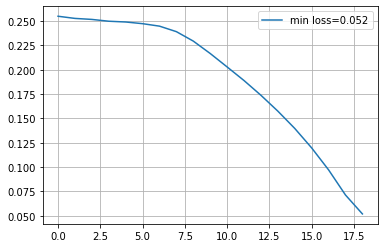

In [14]:
# история изменения значений ф-ции потери
plt.plot(result.history['loss'],label='min loss=%.3f'%(min(result.history['loss'])))
plt.grid()
plt.legend()

## тестируем модель

In [15]:
s = model.predict( tf.cast(X_test,tf.float32) )[:,1]

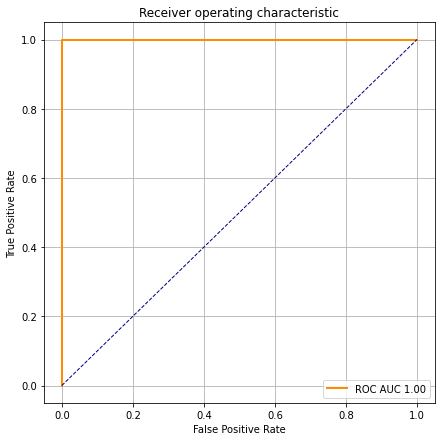

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve( y_test[:,1], s )
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [17]:
# оптимальный порого скора 
#  максимальное количество True Positive при минимальном количестве False Positive
optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
optimal_threshold

0.5029228

In [18]:
p = (s>optimal_threshold).astype(int)
y = y_test[:,1].astype(int)

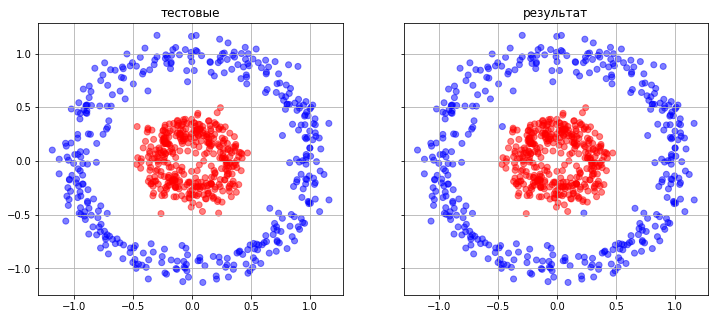

In [19]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y,'тестовые')    
plot_data(ax1,X_test,p,'результат')    
plt.show()

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y,p))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       374
           1       1.00      0.99      1.00       376

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750



## карта скоров

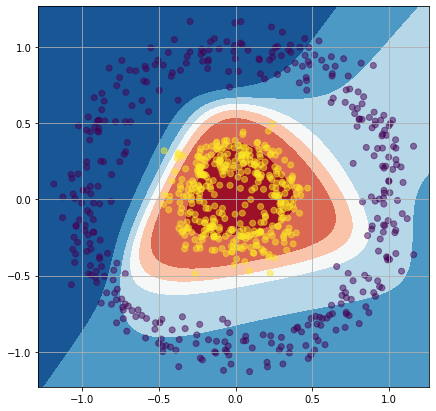

In [21]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=500 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-.1, X_test[:,0].max()+.1, n), 
    np.linspace( X_test[:,1].min()-.1, X_test[:,1].max()+.1, n)
) # узлы сетки

xy = np.vstack([xx.flatten(),yy.flatten() ]).T # разворачиваем сетку 

s = model.predict(tf.cast(xy,tf.float32))[:,1]

plt.figure(figsize=(7,7))
plt.contourf(xx, yy, (1.-s).reshape(n,n), cmap=plt.cm.RdBu)
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=y_test[:,1].astype(int), alpha=.5 )
plt.grid()